IMPORTS

In [1]:
import re
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score,f1_score,fbeta_score,mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score,f1_score,fbeta_score,classification_report
from sklearn.linear_model import LogisticRegression

DATASET ENCODING

In [2]:
def encoding(value):
    if value != '0':
        return 1
    else:
        return 0
    
df=pd.read_csv('Feature_Extracted_Dataset-3.csv')
droplist= ['Sr. No.','Domain Name','Hyphenstring','Homoglyph','Vowel string','Bitsquatting','Insertion string','Omission','Repeatition','Replacement','Subdomain','Transposition','Addition string']
df = df.drop(columns=droplist)

#change boolean features into numeric features
df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))

#change string features into numeric features
df['TLD'] = df['TLD'].apply(encoding)
df['IP Address'] = df['IP Address'].apply(encoding)
df['ASN Number'] = df['ASN Number'].apply(encoding)
df['ASN Country Code'] = df['ASN Country Code'].apply(encoding)
df['ASN CIDR'] = df['ASN CIDR'].apply(encoding)
df['ASN Postal Code'] = df['ASN Postal Code'].apply(encoding)
df['ASN creation date'] = df['ASN creation date'].apply(encoding)
df['ASN updation date'] = df['ASN updation date'].apply(encoding)
X = df.loc[:,df.columns!="Label"]
y = df["Label"]

C:\Users\rohan\AppData\Local\Temp\ipykernel_24584\1449449450.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))


RANDOM FOREST

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

params_grid = {
               'max_depth': [5,10,15],
               'max_features': [4,6,7],
               'min_samples_leaf': [4,7,10],
               'min_samples_split': [5,7,8],
               'n_estimators' : [10,50,100]
               }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
grid_search = GridSearchCV(RandomForestClassifier (random_state = 42), param_grid = params_grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
grid_result = grid_search.fit(X_train, y_train)
print("Best parameters: %s" % (grid_result.best_params_))

gbc_clf2 = RandomForestClassifier(max_depth = grid_result.best_params_.get('max_depth'),
                     max_features = grid_result.best_params_.get('max_features'),
                     min_samples_leaf = grid_result.best_params_.get('min_samples_leaf'),
                     min_samples_split = grid_result.best_params_.get('min_samples_split'),
                     n_estimators=grid_result.best_params_.get('n_estimators'),
                     random_state=42)

gbc_clf2.fit(X_train, y_train)

with open('Random_Forest_model_pickle_dataset-3','wb') as f:
    pickle.dump(gbc_clf2,f)

Best parameters: {'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}


Best parameters: {'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}


PERFORMANCE EVALUATION OF RANDOM FOREST

-------------------------------------Metrics------------------------------------------
Test accuracy score 91.3333
Test Recall 94.0000
Test Precision 89.2405
Test F1 Score 91.5584
Test F2 Score 93.0079
--------------------------TPR, TNR, FPR, FNR------------------------------------------
TPR 0.9400
TNR 0.8867
FPR 0.1133
FNR 0.0600
[[133  17]
 [  9 141]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       150
           1       0.89      0.94      0.92       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



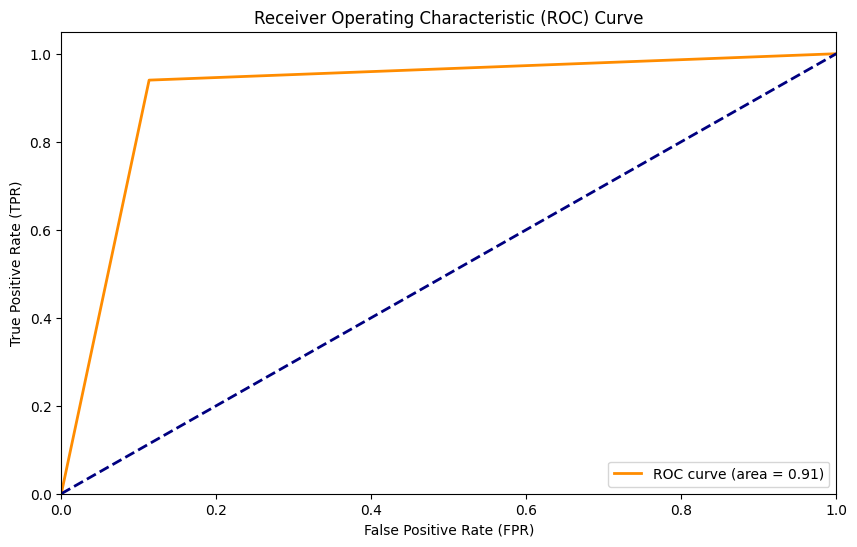

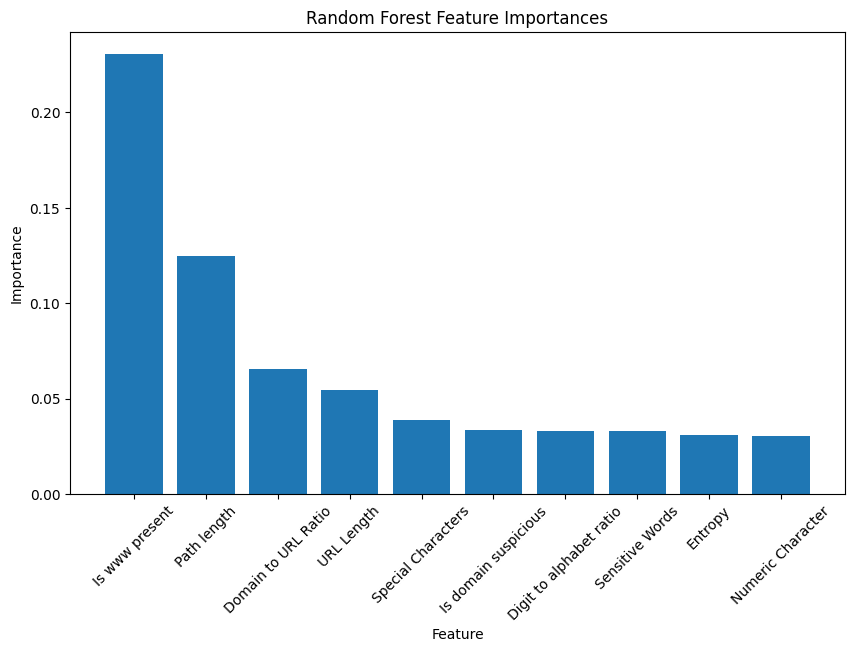

In [4]:
y_train_pred = gbc_clf2.predict(X_train)
y_test_pred = gbc_clf2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

print("-------------------------------------Metrics------------------------------------------")
print("Test accuracy score {:.4f}".format(accuracy_score(y_test, y_test_pred) * 100))
print("Test Recall {:.4f}".format(recall_score(y_test, y_test_pred) * 100))
print("Test Precision {:.4f}".format(precision_score(y_test, y_test_pred) * 100))
print("Test F1 Score {:.4f}".format(f1_score(y_test, y_test_pred) * 100))
print("Test F2 Score {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2.0) * 100))

print("--------------------------TPR, TNR, FPR, FNR------------------------------------------")
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)
FPR = fp / (fp + tn)
FNR = fn / (fn + tp)
print("TPR {:.4f}".format(TPR))
print("TNR {:.4f}".format(TNR))
print("FPR {:.4f}".format(FPR))
print("FNR {:.4f}".format(FNR))
print(confusion_matrix(y_test,y_test_pred))
report = classification_report(y_test, y_test_pred)
print(report)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

feature_importances = gbc_clf2.feature_importances_
feature_names = X.columns  
# Sort the features based on their importance
indices = np.argsort(feature_importances)[::-1]
# Select the top 10 features
top_n = 10
top_indices = indices[:top_n]
# Plot the feature importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[top_indices], align="center")
plt.xticks(range(top_n), feature_names[top_indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.show()

ADABOOST

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

parameters = {
              'n_estimators': [5,50,100],
              'learning_rate': [0.01,0.05,0.1],
              'algorithm': ['SAMME','SAMME.R'],
              'estimator__max_depth': [10,50,100],
              'estimator__max_features': [10,30,50] 
             }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
RD_search = GridSearchCV(AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42),parameters,cv=cv,n_jobs=-1,scoring='accuracy')
RD_result = RD_search.fit(X_train, y_train)
print("Best parameters: %s" % (RD_result.best_params_))

gbc_clf2 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=RD_result.best_params_['estimator__max_depth'], 
                              max_features=RD_result.best_params_['estimator__max_features']),
                              learning_rate=RD_result.best_params_['learning_rate'],
                              n_estimators=RD_result.best_params_['n_estimators'],
                              algorithm=RD_result.best_params_['algorithm'],
                              random_state=42)

gbc_clf2.fit(X_train, y_train)

with open('AdaBoost_model_pickle_dataset-3', 'wb') as f:
    pickle.dump(gbc_clf2, f)

Best parameters: {'algorithm': 'SAMME', 'estimator__max_depth': 10, 'estimator__max_features': 10, 'learning_rate': 0.05, 'n_estimators': 100}


Best parameters: {'algorithm': 'SAMME', 'estimator__max_depth': 10, 'estimator__max_features': 10, 'learning_rate': 0.05, 'n_estimators': 100}


PERFORMANCE EVALUATION OF ADABOOST

-------------------------------------Metrics------------------------------------------
Test accuracy score 91.6667
Test Recall 92.0000
Test Precision 91.3907
Test F1 Score 91.6944
Test F2 Score 91.8775
--------------------------TPR, TNR, FPR, FNR------------------------------------------
TPR 0.9200
TNR 0.9133
FPR 0.0867
FNR 0.0800
[[137  13]
 [ 12 138]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       150
           1       0.91      0.92      0.92       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



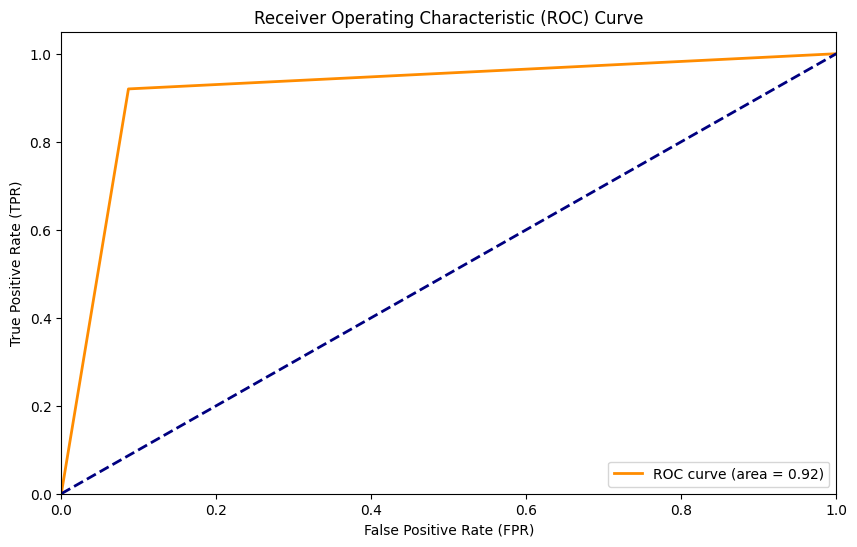

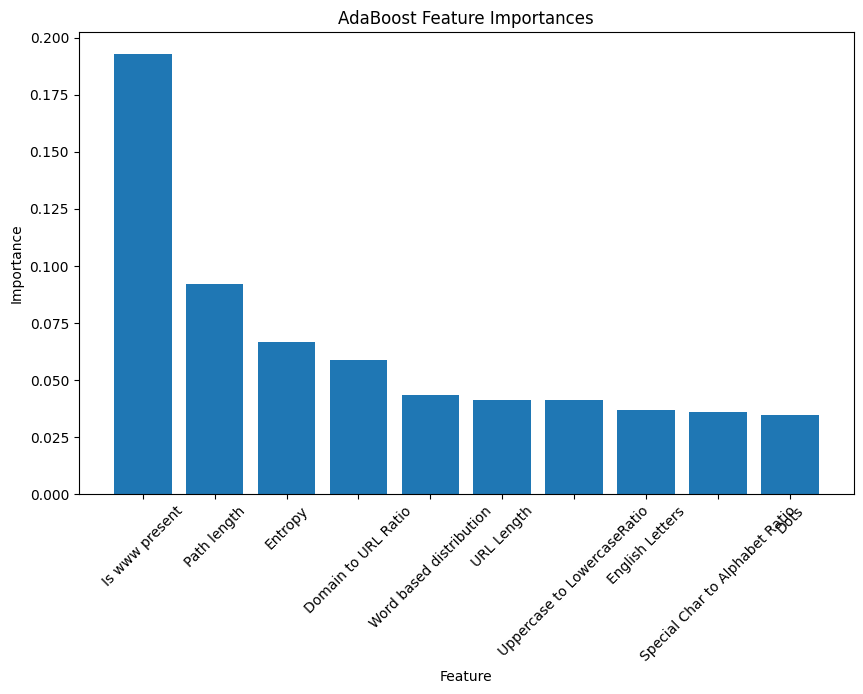

In [6]:
y_train_pred = gbc_clf2.predict(X_train)
y_test_pred = gbc_clf2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

print("-------------------------------------Metrics------------------------------------------")
print("Test accuracy score {:.4f}".format(accuracy_score(y_test, y_test_pred) * 100))
print("Test Recall {:.4f}".format(recall_score(y_test, y_test_pred) * 100))
print("Test Precision {:.4f}".format(precision_score(y_test, y_test_pred) * 100))
print("Test F1 Score {:.4f}".format(f1_score(y_test, y_test_pred) * 100))
print("Test F2 Score {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2.0) * 100))

print("--------------------------TPR, TNR, FPR, FNR------------------------------------------")
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)
FPR = fp / (fp + tn)
FNR = fn / (fn + tp)
print("TPR {:.4f}".format(TPR))
print("TNR {:.4f}".format(TNR))
print("FPR {:.4f}".format(FPR))
print("FNR {:.4f}".format(FNR))
print(confusion_matrix(y_test,y_test_pred))
report = classification_report(y_test, y_test_pred)
print(report)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

feature_importances = gbc_clf2.feature_importances_
feature_names = X.columns  
# Sort the features based on their importance
indices = np.argsort(feature_importances)[::-1]
# Select the top 10 features
top_n = 10
top_indices = indices[:top_n]
# Plot the feature importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[top_indices], align="center")
plt.xticks(range(top_n), feature_names[top_indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("AdaBoost Feature Importances")
plt.show()

GRADIENTBOOST

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

parameters = {
              'loss': ["exponential"],
              'learning_rate': [0.01,0.05],
              'min_samples_split': [2,3,5],
              'min_samples_leaf': [5,9,10],
              'max_depth': [5,10,50],
              'max_features': ["log2"],
              'criterion': ["friedman_mse"],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [10,30,50]
             }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
RD_search = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters, cv=cv, n_jobs=-1, scoring='accuracy')
RD_result = RD_search.fit(X_train, y_train)
print("Best parameters: %s" % (RD_result.best_params_))

gbc_clf2 = GradientBoostingClassifier(learning_rate=RD_result.best_params_.get('learning_rate'),
                                      loss=RD_result.best_params_.get('loss'),
                                      min_samples_split=RD_result.best_params_.get('min_samples_split'),
                                      min_samples_leaf=RD_result.best_params_.get('min_samples_leaf'),
                                      max_depth=RD_result.best_params_.get('max_depth'),
                                      max_features=RD_result.best_params_.get('max_features'),
                                      criterion=RD_result.best_params_.get('criterion'),
                                      subsample=RD_result.best_params_.get('subsample'),
                                      n_estimators=RD_result.best_params_.get('n_estimators'),
                                      random_state=42)

gbc_clf2.fit(X_train, y_train)

with open('GradientBoost_model_pickle_dataset-3','wb') as f:
    pickle.dump(gbc_clf2,f)

Best parameters: {'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'exponential', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.7}


Best parameters: {'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'exponential', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.7}


PERFORMANCE EVALUATION OF GRADIENTBOOST

-------------------------------------Metrics------------------------------------------
Test accuracy score 91.3333
Test Recall 92.6667
Test Precision 90.2597
Test F1 Score 91.4474
Test F2 Score 92.1751
--------------------------TPR, TNR, FPR, FNR------------------------------------------
TPR 0.9267
TNR 0.9000
FPR 0.1000
FNR 0.0733
[[135  15]
 [ 11 139]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       150
           1       0.90      0.93      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



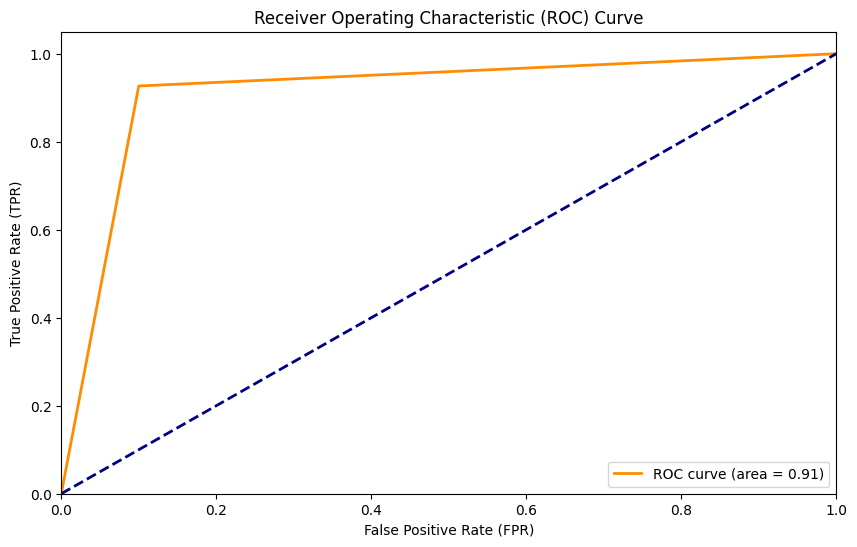

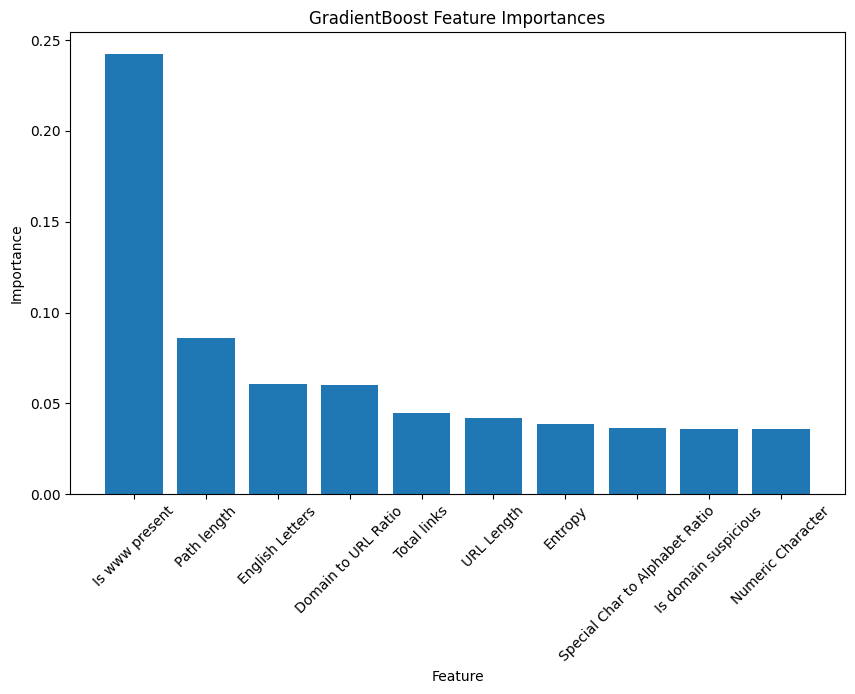

In [8]:
y_train_pred = gbc_clf2.predict(X_train)
y_test_pred = gbc_clf2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

print("-------------------------------------Metrics------------------------------------------")
print("Test accuracy score {:.4f}".format(accuracy_score(y_test, y_test_pred) * 100))
print("Test Recall {:.4f}".format(recall_score(y_test, y_test_pred) * 100))
print("Test Precision {:.4f}".format(precision_score(y_test, y_test_pred) * 100))
print("Test F1 Score {:.4f}".format(f1_score(y_test, y_test_pred) * 100))
print("Test F2 Score {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2.0) * 100))

print("--------------------------TPR, TNR, FPR, FNR------------------------------------------")
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)
FPR = fp / (fp + tn)
FNR = fn / (fn + tp)
print("TPR {:.4f}".format(TPR))
print("TNR {:.4f}".format(TNR))
print("FPR {:.4f}".format(FPR))
print("FNR {:.4f}".format(FNR))
print(confusion_matrix(y_test,y_test_pred))
report = classification_report(y_test, y_test_pred)
print(report)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

feature_importances = gbc_clf2.feature_importances_
feature_names = X.columns  
# Sort the features based on their importance
indices = np.argsort(feature_importances)[::-1]
# Select the top 10 features
top_n = 10
top_indices = indices[:top_n]
# Plot the feature importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[top_indices], align="center")
plt.xticks(range(top_n), feature_names[top_indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("GradientBoost Feature Importances")
plt.show()

XGBOOST

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

parameters = {
              'objective': ['binary:logistic'],
              'learning_rate': [0.05,0.6], 
              'max_depth': [5,7,9],
              'min_child_weight': [4,5,7],
              'subsample': [0.5,0.7],
              'colsample_bytree': [ 0.4,0.2],
              'n_estimators': [10,50],
              'gamma': [0.8,0.9]
              }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
RD = GridSearchCV(xgb.XGBClassifier(random_state=42), parameters, n_jobs=1, cv=cv, scoring='accuracy',verbose=0, refit=True)
RD_result = RD.fit(X_train, y_train)
print("Best parameters: %s" % (RD.best_params_))

gbc_clf2 = xgb.XGBClassifier(objective = RD.best_params_.get('objective'),
                     learning_rate = RD.best_params_.get('learning_rate'),
                     max_depth = RD.best_params_.get('max_depth'),
                     min_child_weight = RD.best_params_.get('min_child_weight'),
                     subsample = RD.best_params_.get('subsample'),
                     colsample_bytree = RD.best_params_.get('colsample_bytree'),
                     n_estimators = RD.best_params_.get('n_estimators'),
                     gamma = RD.best_params_.get('gamma'),
                     random_state=42)

gbc_clf2.fit(X_train, y_train)

with open('XGBoost_model_pickle_dataset-3','wb') as f:
    pickle.dump(gbc_clf2,f)



Best parameters: {'colsample_bytree': 0.4, 'gamma': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 50, 'objective': 'binary:logistic', 'subsample': 0.7}


Best parameters: {'colsample_bytree': 0.4, 'gamma': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 50, 'objective': 'binary:logistic', 'subsample': 0.7}


PERFORMANCE EVALUATION OF XGBOOST

-------------------------------------Metrics------------------------------------------
Test accuracy score 90.3333
Test Recall 92.0000
Test Precision 89.0323
Test F1 Score 90.4918
Test F2 Score 91.3907
--------------------------TPR, TNR, FPR, FNR------------------------------------------
TPR 0.9200
TNR 0.8867
FPR 0.1133
FNR 0.0800
[[133  17]
 [ 12 138]]
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       150
           1       0.89      0.92      0.90       150

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



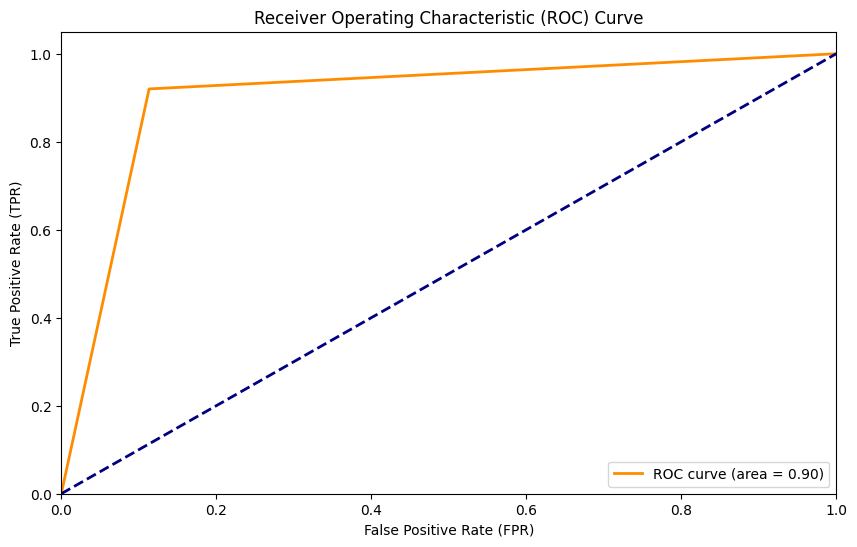

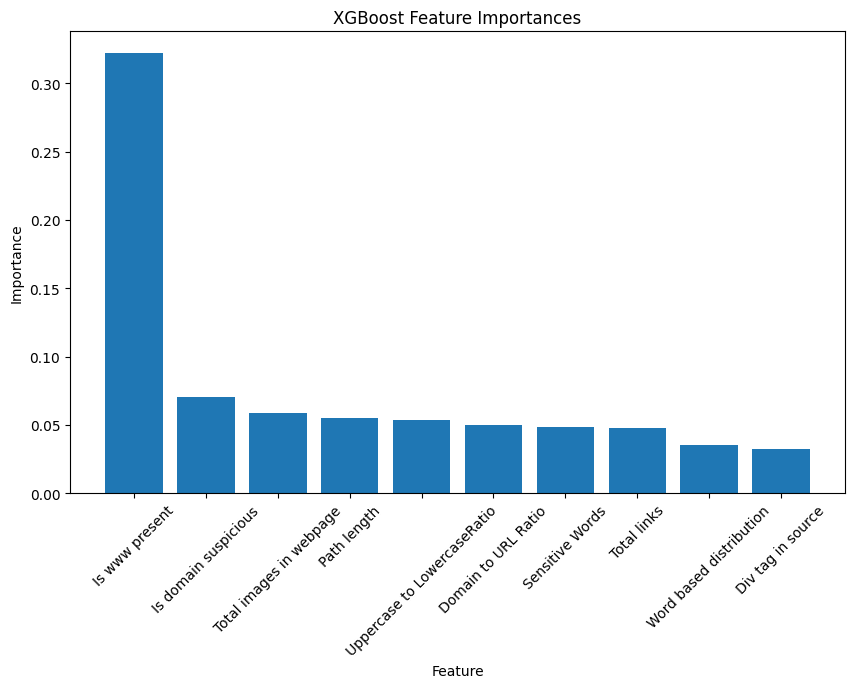

In [10]:
y_train_pred = gbc_clf2.predict(X_train)
y_test_pred = gbc_clf2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

print("-------------------------------------Metrics------------------------------------------")
print("Test accuracy score {:.4f}".format(accuracy_score(y_test, y_test_pred) * 100))
print("Test Recall {:.4f}".format(recall_score(y_test, y_test_pred) * 100))
print("Test Precision {:.4f}".format(precision_score(y_test, y_test_pred) * 100))
print("Test F1 Score {:.4f}".format(f1_score(y_test, y_test_pred) * 100))
print("Test F2 Score {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2.0) * 100))

print("--------------------------TPR, TNR, FPR, FNR------------------------------------------")
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)
FPR = fp / (fp + tn)
FNR = fn / (fn + tp)
print("TPR {:.4f}".format(TPR))
print("TNR {:.4f}".format(TNR))
print("FPR {:.4f}".format(FPR))
print("FNR {:.4f}".format(FNR))
print(confusion_matrix(y_test,y_test_pred))
report = classification_report(y_test, y_test_pred)
print(report)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

feature_importances = gbc_clf2.feature_importances_
feature_names = X.columns  
# Sort the features based on their importance
indices = np.argsort(feature_importances)[::-1]
# Select the top 10 features
top_n = 10
top_indices = indices[:top_n]
# Plot the feature importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[top_indices], align="center")
plt.xticks(range(top_n), feature_names[top_indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances")
plt.show()